#### Load dataframe

In [434]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import torch
import os
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Compose, Lambda, Resize

In [435]:
RANDOM_SEED = 150
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [436]:
calls_df = pd.read_csv('pickles_and_csvs/features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))

In [437]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7282 entries, 0 to 7281
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   track_ID                         7282 non-null   object 
 1   clip_ID                          7282 non-null   object 
 2   goose_ID                         7282 non-null   object 
 3   call_type                        7282 non-null   object 
 4   waveform                         7282 non-null   object 
 5   sr                               7282 non-null   int64  
 6   filepath                         7282 non-null   object 
 7   log_scaled_spectrogram           7282 non-null   object 
 8   lfccs                            7282 non-null   object 
 9   peak                             7282 non-null   float64
 10  duration                         7282 non-null   float64
 11  log_padded_spectrogram           7282 non-null   object 
 12  log_padded_log_freq_

In [438]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[["track_ID", "clip_ID", "goose_ID", "call_type", "log_padded_spectrogram"]]
calls_df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7282 entries, 0 to 7281
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   track_ID                7282 non-null   object
 1   clip_ID                 7282 non-null   object
 2   goose_ID                7282 non-null   object
 3   call_type               7282 non-null   object
 4   log_padded_spectrogram  7282 non-null   object
dtypes: object(5)
memory usage: 284.6+ KB


In [439]:
subset_size = 500
subsample_sizes = {
    'recruitment': subset_size,
    'contact': subset_size,
    'departure': subset_size,
    'distance': subset_size,
    'triumph': subset_size,
    'alarm': subset_size
}

def subsample_group(group):
    call_type = group.name  
    target_size = subsample_sizes.get(call_type, 0)  # Default to 0 if missing

    if len(group) > target_size:
        return group.sample(n=target_size, random_state=RANDOM_SEED)
    return group  # Return full group if it's already smaller than the target size

calls_df.groupby('call_type', group_keys=False)[calls_df.columns.tolist()].apply(subsample_group)

,track_ID,clip_ID,goose_ID,call_type,log_padded_spectrogram
214,GT00052,G00282,Dagobert,alarm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
271,GT00058,G00331,Besenstiel,alarm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
347,GT00055,G00310,Lausbursch,alarm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
693,GT00989,G14235,unknown,alarm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
811,GT00053,G00293,Dagobert,alarm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
7179,GT00976,G12265,Belmont,triumph,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7198,GT00980,G12410,Taiga,triumph,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7205,GT00976,G12296,Belmont,triumph,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7237,GT00984,G12726,Bregenz,triumph,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [440]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

### Variational Autoencoder

In [441]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
N_EPOCHS = 1000
retrain = True

In [442]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


#### Create data loader

In [443]:
calls_df.iloc[0]["log_padded_spectrogram"].shape

(44, 170)

In [444]:
# data augmentation
spectrogram_transforms = Compose([
    Lambda(lambda spec: torch.roll(spec, shifts=random.randint(-40, 40), dims=-1)), # Random shift
    #Lambda(lambda spec: Normalize(spec)), 
])

In [445]:
class SoundDS(Dataset):
    # Custom data loader 
    def __init__(self, calls_df, transform=None):
        self.df = calls_df
        self.transform = transform
        self.resize_transform = Resize((32, 128))

    # of items in dataset
    def __len__(self):
        return len(self.df)    
    
    # Get item through index
    def __getitem__(self, idx):
        spectrogram = torch.from_numpy(self.df.iloc[idx]["log_padded_spectrogram"]).to(torch.float32).to(device)
        spectrogram = spectrogram[np.newaxis, ...]
        spectrogram = self.resize_transform(spectrogram.cpu()).to(device)
        
        if self.transform:
            spectrogram = spectrogram_transforms(spectrogram)
        return spectrogram, self.df.iloc[idx]["encoded_call_type"], self.df.iloc[idx]["clip_ID"]

In [446]:
ds = SoundDS(calls_df, transform=True)

# Random split for train:val - 80:20
num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(ds, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [447]:
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [448]:
train_features, train_labels, _ = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])
print(torch.isnan(train_features).any())
assert torch.all((train_features >= 0) & (train_features <= 1)), "Not all values are between 0 and 1."

Feature batch shape: torch.Size([32, 1, 32, 128])
32 128
tensor(False, device='mps:0')


#### Define architecture

In [449]:
class ConvolutionalAutoencoder32by128(torch.nn.Module):
    # from https://jyopari.github.io/VAE.html, https://github.com/pytorch/examples/blob/main/vae/main.py
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            # input shape (n, 1, 44, 170)
            torch.nn.Conv2d(1, 8, (3,3), (1,1), (1,1)), # output shape (n, 8, 32, 128) 
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(8, 16, (4,4), (2,2), (1,1)), # output shape (n, 16, 16, 64)
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 24, (3,3), (1,1), (1,1)), # output shape (n, 32, 16, 64)
            torch.nn.BatchNorm2d(24),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(24, 32, (4,4), (2,2), (1,1)), # output shape (n, 64, 8, 32)
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, (4,4), (2,2), (1,1)), # output shape (n, 64, 4, 16)
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            # torch.nn.Linear(8192, 4096),
            # torch.nn.LeakyReLU(),
            torch.nn.Linear(4096, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 256),
        )

        # latent mean and variance 
        self.mean_layer = torch.nn.Linear(256, 128)
        self.sigma_layer = torch.nn.Linear(256, 128)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 4096),
            # torch.nn.LeakyReLU(),
            # torch.nn.Linear(4096, 8192),
            torch.nn.Unflatten(1, (64, 4, 16)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.ConvTranspose2d(64, 32, (4,4), (2,2), (1,1)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.ConvTranspose2d(32, 24, (4,4), (2,2), (1,1)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(24),
            torch.nn.ConvTranspose2d(24, 16, (3,3), (1,1), (1,1)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.ConvTranspose2d(16, 8, (4,4), (2,2), (1,1)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(8),
            torch.nn.ConvTranspose2d(8, 1, (3,3), (1,1), (1,1)),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        #x = torch.from_numpy(resize(x.cpu().numpy(), (256, 1, 49, 129))).to(device).size()
        x = self.encoder(x)
        mean, sigma = self.mean_layer(x), self.sigma_layer(x)
        return mean, sigma

    def decode(self, x):
        return self.decoder(x)
    
    def reparameterization(self, mean, sigma):
        std = torch.exp(0.5*sigma)
        epsilon = torch.randn_like(sigma).to(device)      
        return mean + std*epsilon

    def forward(self, x):
        mean, sigma = self.encode(x)
        z = self.reparameterization(mean, sigma)
        x_hat = self.decode(z)
        return x_hat, mean, sigma

In [450]:
# class ConvolutionalAutoencoder(torch.nn.Module):
#     # from https://jyopari.github.io/VAE.html, https://github.com/pytorch/examples/blob/main/vae/main.py
#     def __init__(self):
#         super().__init__()

#         self.encoder = torch.nn.Sequential(
#             # input shape (n, 1, 44, 170)
#             torch.nn.Conv2d(1, 8, (4,4), (2,2), (1,1)), # output shape (n, 8, 22, 85) 
#             torch.nn.BatchNorm2d(8),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(8, 16, (4,3), (2,2), (1,1)), # output shape (n, 16, 11, 43)
#             torch.nn.BatchNorm2d(16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(16, 32, (3,3), (2,2), (1,1)), # output shape (n, 32, 6, 22)
#             torch.nn.BatchNorm2d(32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(32, 64, (2,4), (2,2), (1,1)), # output shape (n, 64, 4, 11)
#             torch.nn.BatchNorm2d(64),
#             torch.nn.LeakyReLU(),
#             torch.nn.Flatten(),
#             torch.nn.Linear(2816, 1024),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(1024, 512),
#         )

#         # latent mean and variance 
#         self.mean_layer = torch.nn.Linear(512, 128)
#         self.sigma_layer = torch.nn.Linear(512, 128)
        
#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(128, 512),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(512, 1024),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(1024, 2816),
#             torch.nn.Unflatten(1, (64, 4, 11)),
#             torch.nn.LeakyReLU(),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.ConvTranspose2d(64, 32, (2,4), (2,2), (1,1)),
#             torch.nn.LeakyReLU(),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.ConvTranspose2d(32, 16, (3,3), (2,2), (1,1)),
#             torch.nn.LeakyReLU(),
#             torch.nn.BatchNorm2d(16),
#             torch.nn.ConvTranspose2d(16, 8, (4,3), (2,2), (1,1)),
#             torch.nn.LeakyReLU(),
#             torch.nn.BatchNorm2d(8),
#             torch.nn.ConvTranspose2d(8, 1, (4,4), (2,2), (1,1)),
#             torch.nn.Sigmoid()
#         )

#     def encode(self, x):
#         #x = torch.from_numpy(resize(x.cpu().numpy(), (256, 1, 49, 129))).to(device).size()
#         x = self.encoder(x)
#         mean, sigma = self.mean_layer(x), self.sigma_layer(x)
#         return mean, sigma

#     def decode(self, x):
#         return self.decoder(x)
    
#     def reparameterization(self, mean, sigma):
#         std = torch.exp(0.5*sigma)
#         epsilon = torch.randn_like(sigma).to(device)      
#         return mean + std*epsilon

#     def forward(self, x):
#         mean, sigma = self.encode(x)
#         z = self.reparameterization(mean, sigma)
#         x_hat = self.decode(z)
#         return x_hat, mean, sigma

In [451]:
def conv_output_shape(input_shape, kernel_size, stride, padding):
    # Calculate output shape of Conv2d layer
    H_in, W_in = input_shape
    kernel_h, kernel_w = kernel_size
    stride_h, stride_w = stride
    padding_h, padding_w = padding
    
    # Output height and width calculation
    H_out = (H_in - kernel_h + 2 * padding_h) / stride_h + 1
    W_out = (W_in - kernel_w + 2 * padding_w) / stride_w + 1
    
    return (H_out, W_out)

conv_output_shape((8, 32), (4,4), (2,2), (1,1))

(4.0, 16.0)

In [452]:
# class ConvolutionalAutoencoder2(torch.nn.Module):
#     # from https://jyopari.github.io/VAE.html, https://github.com/pytorch/examples/blob/main/vae/main.py
#     def __init__(self):
#         super().__init__()

#         self.encoder = torch.nn.Sequential(
#             # input shape (n, 1, 44, 170)
#             torch.nn.Conv2d(1, 16, (4,4), (2,2), (1,1)), # output shape (n, 16, 22, 85) 
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(16, 32, (2,3), (2,2), (1,1)), # output shape (n, 32, 12, 43)
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(32, 64, (2,3), (2,2), (1,1)), # output shape (n, 64, 7, 22)
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(64, 128, (3,2), (2,2), (1,1)), # output shape (n, 128, 4, 12)
#             torch.nn.LeakyReLU(),
#             torch.nn.Flatten(), 
#             torch.nn.Linear(6144, 1024),
#         )

#         # latent mean and variance 
#         self.mean_layer = torch.nn.Linear(1024, 128)
#         self.sigma_layer = torch.nn.Linear(1024, 128)

#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(128, 1024),
#             torch.nn.Linear(1024, 6144),
#             torch.nn.Unflatten(1, (128, 4, 12)),
#             torch.nn.LeakyReLU(),
#             torch.nn.ConvTranspose2d(128, 64, (3,2), (2,2), (1,1)),
#             torch.nn.LeakyReLU(),
#             torch.nn.ConvTranspose2d(64, 32, (2,3), (2,2), (1,1)),
#             torch.nn.LeakyReLU(),
#             #torch.nn.BatchNorm2d(12),
#             torch.nn.ConvTranspose2d(32, 16, (2,3), (2,2), (1,1)),
#             torch.nn.LeakyReLU(),
#             #torch.nn.BatchNorm2d(8),
#             torch.nn.ConvTranspose2d(16, 1, (4,4), (2,2), (1,1)),
#             torch.nn.Sigmoid()
#         )

#     def encode(self, x):
#         x = self.encoder(x)
#         mean, sigma = self.mean_layer(x), self.sigma_layer(x)
#         return mean, sigma

#     def decode(self, x):
#         return self.decoder(x)
    
#     def reparameterization(self, mean, sigma):
#         std = torch.exp(0.5*sigma)
#         epsilon = torch.randn_like(sigma).to(device)      
#         return mean + std*epsilon

#     def forward(self, x):
#         mean, sigma = self.encode(x)
#         z = self.reparameterization(mean, sigma)
#         x_hat = self.decode(z)
#         return x_hat, mean, sigma

In [453]:
def loss_function(x, x_hat, mean, sigma, beta=1.0):
    #assert torch.all((x >= 0) & (x <= 1)) and torch.all((x_hat >= 0) & (x_hat <= 1)), f"Not all values are between 0 and 1. Min: {x.min().item(), x_hat.min().item()}, max: {x.max().item(), x_hat.max().item()}"
    # Reconstruction Loss (BCE) - better suited for fine grained comparison of input and reconstruction
    recon_loss = torch.nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")  # Summed over all elements
    assert recon_loss != None, print("reconstruction loss was not calculated")
    
    # Kullback-Leibler Divergence
    # Kingma and Welling. Auto-Encoding Variational Bayes. 2013
    # https://arxiv.org/abs/1312.6114
    kl_divergence = -0.5 * torch.sum(1 + sigma - mean.pow(2) - sigma.exp())
    return recon_loss + beta * kl_divergence

In [454]:
class EarlyStopper:
    # adapted from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if self.min_validation_loss - validation_loss > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [455]:
def train(model, optimizer, train_dl, val_dl, epochs, device, early_stopper, beta):
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(layer.weight) 
    model.train()  # Set model to training mode
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Training loop
        train_loss = 0
        for batch_idx, (x, _, _) in enumerate(train_dl):
            x = x.to(device)

            optimizer.zero_grad()  # Reset gradients
            
            # Forward pass
            x_hat, mean, sigma = model(x)
            
            # Compute loss
            loss = loss_function(x, x_hat, mean, sigma, beta)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_dl.dataset)  # Average loss over the entire dataset
        train_losses.append(train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        with torch.no_grad():  # Disable gradient calculation
            for batch_idx, (x, _, _) in enumerate(val_dl):
                x = x.to(device)  # Move data to device
                
                # Forward pass
                x_hat, mean, sigma = model(x)
                
                # Compute loss
                loss = loss_function(x, x_hat, mean, sigma, beta)
                val_loss += loss.item()
        
        val_loss /= len(val_dl.dataset)  # Average loss over the validation dataset
        val_losses.append(val_loss)
        # Print epoch statistics
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        
        # Early stopping check
        if early_stopper.early_stop(val_loss):
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
    
    return model, train_losses, val_losses

In [456]:
model = ConvolutionalAutoencoder32by128()
model.to(device)
print(model)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopper(patience=5, min_delta=.0001)

if retrain:
    trained_model, train_losses, val_losses = train(
            model=model,
            optimizer=optimizer,
            train_dl=train_dl,
            val_dl=val_dl,
            epochs=N_EPOCHS,
            device=device,
            early_stopper=early_stopper,
            beta=.1
        )

ConvolutionalAutoencoder32by128(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [465]:
if retrain:
    torch.save(trained_model.state_dict(), f"/Users/lenagies/Desktop/Master/Thesis/geese/code/GooseVocalizations/vae_weights/convolutional_vae_weights_adam.pth")
# else:
#     model.load_state_dict(torch.load("/Users/lenagies/Desktop/Master/Thesis/geese/code/GooseVocalizations/vae_weights/convolutional_vae_weights_sgd_2.pth", map_location=device, weights_only=True))

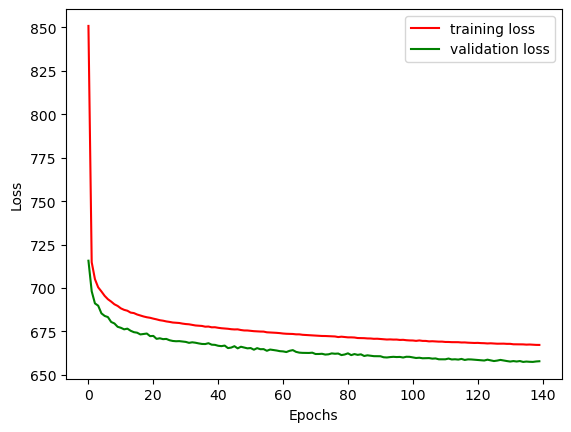

In [458]:
if retrain:
    plt.plot(train_losses[1:], color='r', label='training loss')
    plt.plot(val_losses[1:], color='g', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')  
    plt.legend()
    plt.show()

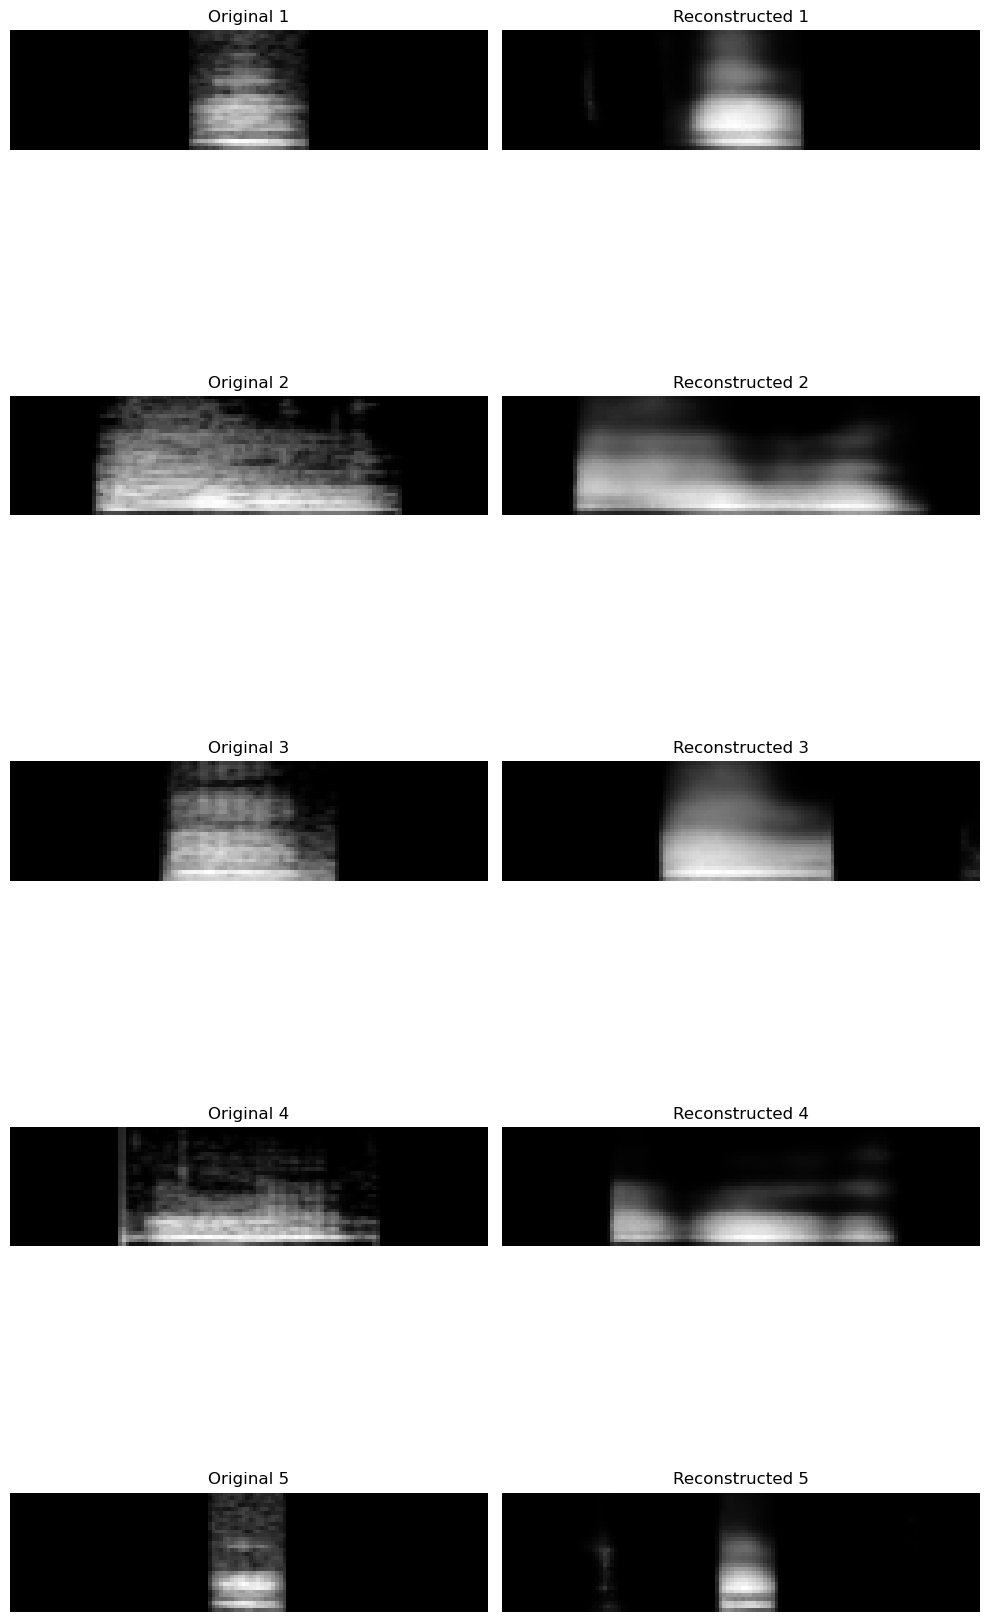

In [459]:
def plot_real_and_decoded_calls(train_dl, num_samples=5):
    # Get a batch of data from the DataLoader
    train_features, train_labels, _ = next(iter(train_dl))
    
    # Ensure data is moved to the same device as the model
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        # Original call from dataset
        real_call = train_features[i].cpu().detach().numpy().reshape(32, 128)
        
        # Get latent representation of real call
        mean, log_var = model.encode(train_features[i].unsqueeze(0))  # Unsqueeze to add batch dimension
        z = model.reparameterization(mean, torch.exp(0.5 * log_var))
        
        # Decode latent vector to generate reconstructed call
        decoded_call = model.decode(z).detach().cpu().numpy().reshape(32, 128)
        
        # Plot original call
        axes[i, 0].imshow(real_call, origin='lower', cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Original {i+1}")
        
        # Plot reconstructed call
        axes[i, 1].imshow(decoded_call, origin='lower', cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Reconstructed {i+1}")
    
    plt.tight_layout()
    plt.show()

ds = SoundDS(calls_df) # Initialize again without transforms
full_dl = DataLoader(ds, batch_size=len(ds), shuffle=True)
plot_real_and_decoded_calls(full_dl, num_samples=5)


In [460]:
representations = []
with torch.no_grad():
    for batch_idx, (X, y, clip_id) in enumerate(full_dl):
        X, y = X.to(device), y.to(device)
        mean, sigma = model.encode(X)
        z = model.reparameterization(mean, sigma)

        for i in range(len(y)):
            representations.append([clip_id[i], y[i].item(), z[i].cpu().tolist()])

In [461]:
column_names = ["clip_ID", "call_type", "latent_representation"]

In [462]:
representations_df = pd.DataFrame(representations, columns=column_names, index=None) 
representations_df.head()

,clip_ID,call_type,latent_representation
0,G01285,1,"[-0.15737172961235046, -0.6093846559524536, -0..."
1,G09930,4,"[-1.514164924621582, -0.1543048918247223, 0.67..."
2,G12146,5,"[-0.07095397263765335, 0.32734012603759766, -1..."
3,G08560,1,"[1.4045467376708984, -1.8446109294891357, 0.21..."
4,G00607,6,"[-0.2890435457229614, -0.17680425941944122, 0...."


In [464]:
#representations_df["latent_representation"] = representations_df["latent_representation"].apply(lambda x: json.dumps(x.tolist()))
representations_df.to_csv('latent_representations_CVAE_adam.csv', index=False)